In [1]:
from pprint import pp
from typing import Counter

import joblib
import pandas as pd
from matplotlib import pyplot as plt

# uncomment below before running for the first time
# import nltk
# nltk.download('stopwords', download_dir='.env/nltk_data')

TRAIN_PATH = "absc_data/train.csv"
TEST_PATH = "absc_data/test.csv"

Read train data and test data.

In [2]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [3]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (4840, 6)
Test shape: (1211, 6)


In [4]:
train.head()

,Unnamed: 0,id,Sentence,Aspect Term,Polarity,Category
0,5911,292,I went with 5 friends and we lingered at the t...,table,neutral,Restaurant
1,1867,32,"First, it does not have a push button to open ...",lid,neutral,Laptop
2,5680,474,"Save your money and don't waste your calories,...",service,positive,Restaurant
3,2918,954,After passing by this restaurant for sometime ...,dinner,neutral,Restaurant
4,2885,1971,The sides were ok and incredibly salty.,sides,negative,Restaurant


In [5]:
test.head()

,Unnamed: 0,id,Sentence,Aspect Term,Polarity,Category
0,4876,1305,"In fact, while leaving the place we saw two pe...",menu,neutral,Restaurant
1,3114,1293,"Their calzones are horrific, bad, vomit-induci...",calzones,negative,Restaurant
2,3518,228,We had champagne and caviar and felt like prin...,champagne,positive,Restaurant
3,2299,2595,Keyboard was also very nice and had a solid feel.,Keyboard,positive,Laptop
4,1694,2507,"PC users work in Word, while Mac users work in...",Word,neutral,Laptop


### Part A

1. Find the 5 most frequently occurring aspects in the training set for each category (`restaurant` and `laptop`) and visualize the data (category and frequency) using a bar graph (use matplotlib library). You should have 2 bar graphs (one for each category).

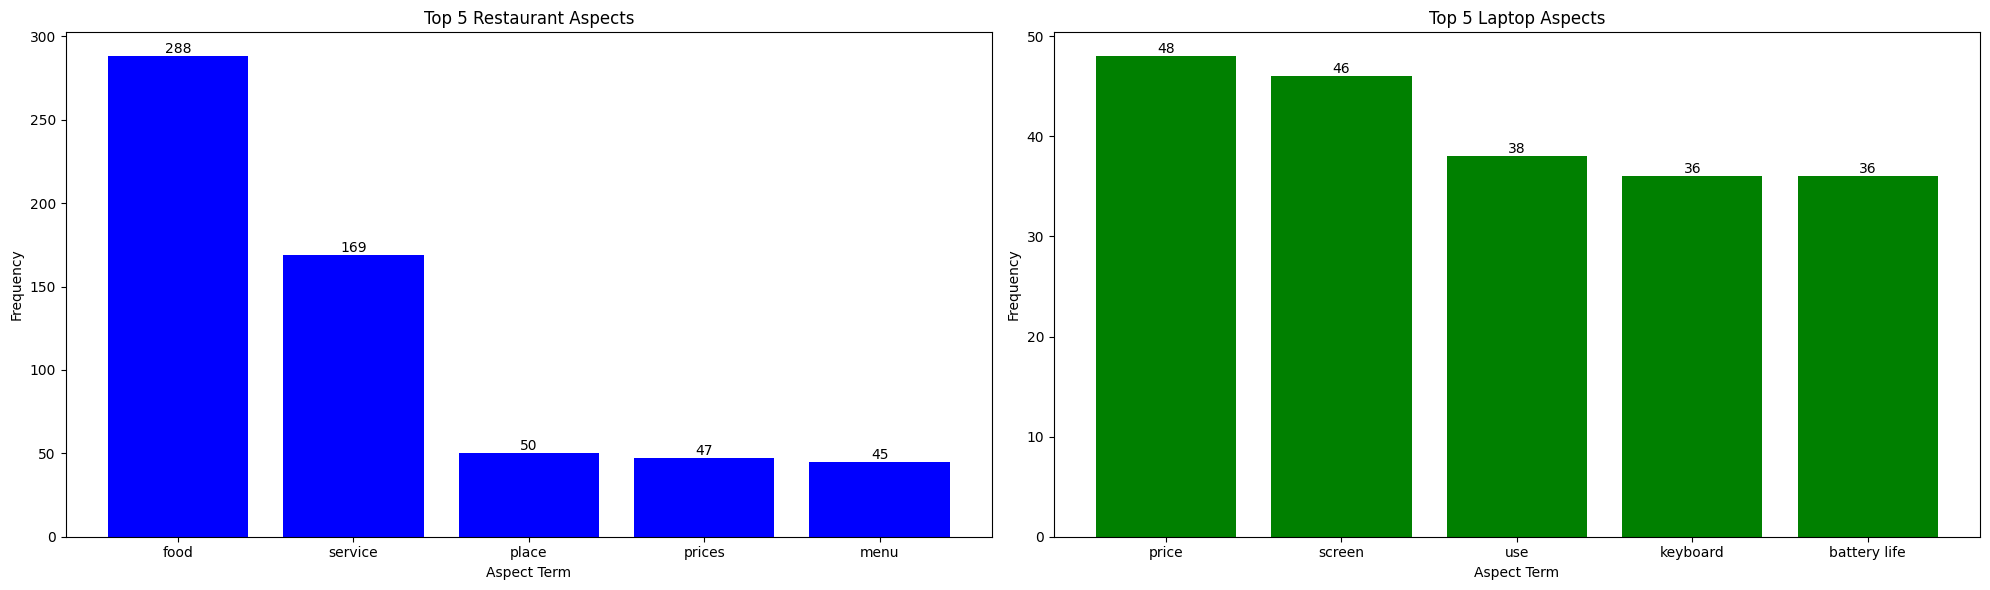

In [6]:
# Filter the data for each category
restaurant_aspects = train[train['Category'] == 'Restaurant']['Aspect Term']
laptop_aspects = train[train['Category'] == 'Laptop']['Aspect Term']

# Count the frequency of each aspect term
restaurant_aspect_counts = Counter(restaurant_aspects)
laptop_aspect_counts = Counter(laptop_aspects)

# Get the 5 most common aspects for each category
top_5_restaurant_aspects = restaurant_aspect_counts.most_common(5)
top_5_laptop_aspects = laptop_aspect_counts.most_common(5)

# Separate the aspect terms and their counts for plotting
restaurant_aspects, restaurant_counts = zip(*top_5_restaurant_aspects)
laptop_aspects, laptop_counts = zip(*top_5_laptop_aspects)

# Plot the bar graphs
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Restaurant aspects bar graph
axes[0].bar(restaurant_aspects, restaurant_counts, color='blue')
axes[0].set_title('Top 5 Restaurant Aspects')
axes[0].set_xlabel('Aspect Term')
axes[0].set_ylabel('Frequency')

# add counts over the bars
for i, count in enumerate(restaurant_counts):
    axes[0].text(i, count, str(count), ha='center', va='bottom')

# Laptop aspects bar graph
axes[1].bar(laptop_aspects, laptop_counts, color='green')
axes[1].set_title('Top 5 Laptop Aspects')
axes[1].set_xlabel('Aspect Term')
axes[1].set_ylabel('Frequency')

# add counts over the bars
for i, count in enumerate(laptop_counts):
    axes[1].text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

2) Find the distribution of the number of aspects per sentence (the same sentence can contain multiple aspects) in the entire training set and visualize the data using a bar graph. You can check for sentences having 1, 2, 3 and more than 3 aspects. You should have a single bar graph.

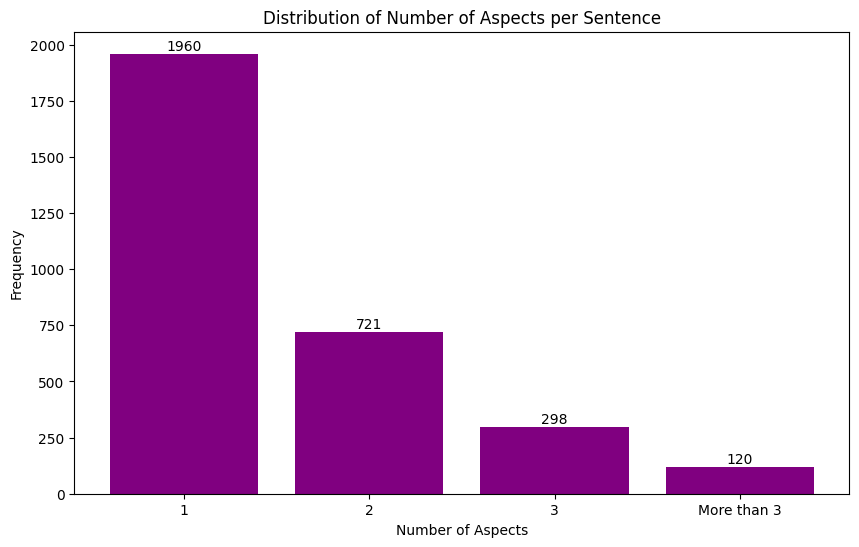

In [9]:
# Group by sentence and count the number of aspects per sentence
aspect_counts_per_sentence = train.groupby('Sentence')['Aspect Term'].count()

# Categorize the counts
aspect_distribution = aspect_counts_per_sentence.apply(
    lambda x: '1' if x == 1
    else ('2' if x == 2
          else ('3' if x == 3
                else 'More than 3')))

# Count the frequency of each category
aspect_distribution_counts = aspect_distribution.value_counts().sort_index()

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(aspect_distribution_counts.index,
        aspect_distribution_counts.values, color='purple')
plt.title('Distribution of Number of Aspects per Sentence')
plt.xlabel('Number of Aspects')
plt.ylabel('Frequency')

# add counts over the bars
for i, count in enumerate(aspect_distribution_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

### Part B

1. Support Vector Machine (SVM) based sentiment classifier

In [7]:
# Preprocessing
def concatenate_aspect_sentence(row: pd.DataFrame) -> str:
    return f"{row['Aspect Term']} [SEP] {row['Sentence']}"


X_train = train.apply(concatenate_aspect_sentence, axis=1)
X_test = test.apply(concatenate_aspect_sentence, axis=1)

y_train = train['Polarity']
y_test = test['Polarity']

In [8]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

# Model Creation
pipeline = make_pipeline(
    TfidfVectorizer(
        stop_words=stopwords.words('english'),
        max_features=5000,
    ),
    SVC(),
)

# Hyperparameter Optimization
param_grid = {
    'svc__C': [i*j
               for i in [0.1, 1, 10]
               for j in [1, 3]
               ],
    'svc__kernel': ['linear', 'rbf'],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Model Training
best_model = grid_search.best_estimator_
print("Best Model Parameters:")
pp(grid_search.best_params_)
best_model.fit(X_train, y_train)

# save the model
joblib.dump(best_model, 'svm_model.joblib')

Best Model Parameters:
{'svc__C': 3, 'svc__kernel': 'rbf'}


['svm_model.joblib']


Test Set Performance:
              precision    recall  f1-score   support

    conflict    0.33333   0.17647   0.23077        17
    negative    0.68935   0.68935   0.68935       338
     neutral    0.60119   0.44298   0.51010       228
    positive    0.77730   0.86146   0.81722       628

    accuracy                        0.72502      1211
   macro avg    0.60029   0.54257   0.56186      1211
weighted avg    0.71336   0.72502   0.71548      1211



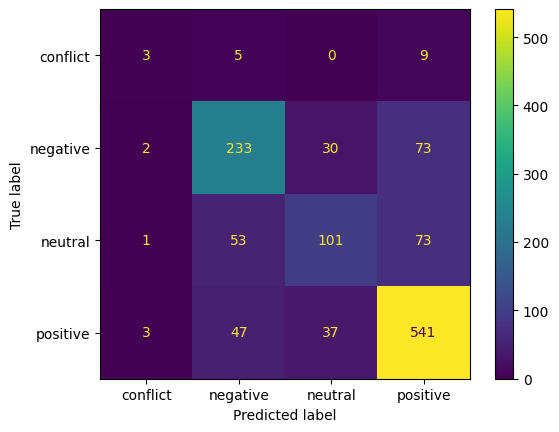

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# load the model
best_model = joblib.load('svm_model.joblib')

# Model Evaluation
y_pred_test = best_model.predict(X_test)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred_test, digits=5))

# print confusion matrix
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)

2. BERT based classifier (bert base uncased)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm, trange

In [11]:
train = pd.read_csv(TRAIN_PATH)
train, val = train_test_split(train, test_size=0.25, random_state=42)
test = pd.read_csv(TEST_PATH)

print(len(train), len(val), len(test))

3630 1210 1211


In [12]:
# Constants
CLASSES = train['Polarity'].unique()
NUM_CLASSES = len(CLASSES)
CLASS2INDEX = {c: i for i, c in enumerate(CLASSES)}
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
class BertDataset(Dataset):
    def __init__(self, data, tokenizer, *, max_len=128):
        super(BertDataset, self).__init__()
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
    # END __init__

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = f"{row['Aspect Term']} [SEP] {row['Sentence']}"
        label = NUM_CLASSES * [0]
        label[CLASS2INDEX[row['Polarity']]] = 1

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'label': torch.tensor(label)
        }
    # END __getitem__
# END BertDataset

In [14]:
class BertModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(BertModel, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(model_name)
        self.out = nn.Linear(self.bert.config.hidden_size, num_classes)
    # END __init__

    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=False
        )
        return self.out(output)
    # END forward
# END BertModel

In [15]:
BATCH_SIZE = 128
MAX_LEN = 100
SAVE_PATH = "bert_model.pth"

tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = BertDataset(train, tokenizer, max_len=MAX_LEN)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_dataset = BertDataset(val, tokenizer, max_len=MAX_LEN)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
)

In [ ]:
EPOCHS = 50
LEARNING_RATE = 1e-3

model = BertModel("bert-base-uncased", NUM_CLASSES)
model.load_state_dict(torch.load(SAVE_PATH, weights_only=True))

model = model.to(DEVICE, non_blocking=True)
for bert_param in model.bert.parameters():
    bert_param.requires_grad = False

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [ ]:
best_acc = 0
for epoch in trange(EPOCHS):
    tqdm.write(f"\nEpoch {epoch + 1}/{EPOCHS}")

    correct = 0
    train_loss = 0

    tqdm.write("Training...")
    model.train()
    for i, batch in tqdm(enumerate(train_loader),
                         leave=False,
                         total=len(train_loader),
                         colour='magenta'):
        input_ids = batch['input_ids'].to(DEVICE, non_blocking=True)
        attention_mask = batch['attention_mask'].to(DEVICE, non_blocking=True)
        token_type_ids = batch['token_type_ids'].to(DEVICE, non_blocking=True)
        label = batch['label'].to(DEVICE, non_blocking=True)

        optimizer.zero_grad()
        output = model(input_ids, attention_mask, token_type_ids)
        label = label.type_as(output)
        loss = loss_fn(output, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(output, dim=1)
        correct += torch.sum(pred == torch.argmax(label, dim=1)).item()
    # END for i, batch in enumerate(train_loader)

    tqdm.write(f"Training Loss:            {train_loss / len(train)}")
    tqdm.write(f"Training Accuracy:        {correct / len(train)}")

    correct = 0
    val_loss = 0

    tqdm.write("\nValidating...")
    with torch.inference_mode():
        model.eval()
        for batch in tqdm(val_loader, leave=False, colour='green'):
            input_ids = batch['input_ids'].to(DEVICE, non_blocking=True)
            attention_mask = batch['attention_mask'].to(
                DEVICE, non_blocking=True)
            token_type_ids = batch['token_type_ids'].to(
                DEVICE, non_blocking=True)
            label = batch['label'].to(DEVICE, non_blocking=True)

            output = model(input_ids, attention_mask, token_type_ids)
            label = label.type_as(output)
            loss = loss_fn(output, label)
            val_loss += loss.item()

            _, pred = torch.max(output, dim=1)
            correct += torch.sum(pred == torch.argmax(label, dim=1)).item()
        # END for batch in val_loader
    # END with torch.inference_mode()

    val_acc = correct / len(val)

    tqdm.write(f"Validation Loss:          {val_loss / len(val)}")
    tqdm.write(f"Validation Accuracy:      {val_acc}")
    tqdm.write(f"Best Validation Accuracy: {best_acc}")

    if val_acc > best_acc:
        tqdm.write("Saving model...\n")
        best_acc = val_acc
        torch.save(model.state_dict(), SAVE_PATH)
    # END if val_loss < best_loss
# END for epoch in trange(EPOCHS)

In [16]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")
test_dataset = BertDataset(test, tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
)

In [17]:
model = BertModel("bert-base-uncased", NUM_CLASSES)
model.load_state_dict(torch.load(SAVE_PATH, weights_only=True))
model = model.to(DEVICE, non_blocking=True)
model.eval()

loss_fn = nn.CrossEntropyLoss()
correct = []
preds = []
test_loss = 0

with torch.inference_mode():
    for batch in tqdm(test_loader, colour='cyan'):
        input_ids = batch['input_ids'].to(DEVICE, non_blocking=True)
        attention_mask = batch['attention_mask'].to(DEVICE, non_blocking=True)
        token_type_ids = batch['token_type_ids'].to(DEVICE, non_blocking=True)
        label = batch['label'].to(DEVICE, non_blocking=True)

        output = model(input_ids, attention_mask, token_type_ids)
        label = label.type_as(output)
        loss = loss_fn(output, label)
        test_loss += loss.item()

        corr = torch.argmax(label, dim=1).numpy(force=True)
        pred = torch.argmax(output, dim=1).numpy(force=True)

        correct.extend(corr)
        preds.extend(pred)
    # END for batch in test_loader
# END with torch.inference_mode()

tqdm.write(f"Test Loss: {test_loss / len(test)}")

  0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.006327132662892046


              precision    recall  f1-score   support

    positive    0.75928   0.87898   0.81476       628
     neutral    0.57037   0.33772   0.42424       228
    negative    0.65043   0.67160   0.66084       338
    conflict    0.00000   0.00000   0.00000        17

    accuracy                        0.70685      1211
   macro avg    0.49502   0.47207   0.47496      1211
weighted avg    0.68268   0.70685   0.68684      1211



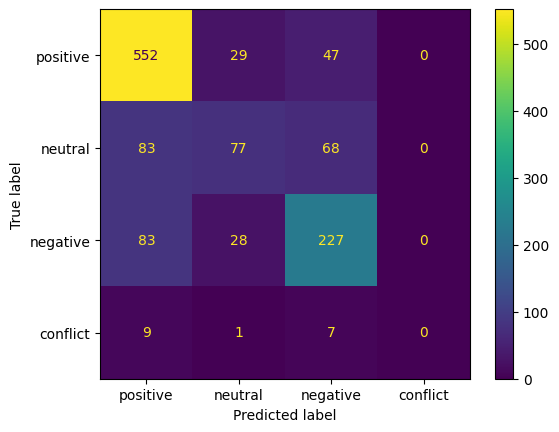

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

print(classification_report(correct, preds, target_names=CLASSES, zero_division=0, digits=5))
cm_display = ConfusionMatrixDisplay.from_predictions(
    correct, preds, display_labels=CLASSES)